In [1]:
import pandas as pd

# Load your CSV file into a DataFrame
df = pd.read_csv(r"C:\Users\bpsad\Desktop\AIML_SRL\AIML _NLP_PROJECT\output_sem_role_zr1.csv")

# Display the first few rows of the DataFrame
print(df)




               tweet_id                                              tweet  \
0              tweet_id                                              tweet   
1    837746741063593992  A good over by hasan ali but iska over bachana...   
2    838703117810085888  Dogs are loyal, par un he se koi shadi nahi ka...   
3    763674497933336576   Apny bachon ko sikhaon ga "Grades don't matter."   
4    748246556998959104         Highlight of the night\nKe lights nai hai.   
..                  ...                                                ...   
739  838434401130278913        Current run rate dekh kar sharam a Rai hay!   
740  838456430848061445                Pakistan ki khushi over everything    
741  838717126277898240  One more day where I've decided, KAL SE PAKKA ...   
742  842114263921614850  Sony se pehly apny favt songs ki lyrics post k...   
743  842405293896134656  Mardam shumari mai double faced logo ka kya ho...   

                                                tokens  \
0    

In [2]:
# Check for missing values
print(df.isnull().sum())

# Drop irrelevant columns
df = df[['tweet_id', 'semantic_roles', 'tweet','tokens','language_ids','pos_tags' ]]
# Assuming 'Semantic_Role' is a string representation of a list, for example: "['ARG1', '_', 'ARG2']"
df['semantic_roles'] = df['semantic_roles'].apply(eval)



tweet_id          0
tweet             0
tokens            0
semantic_roles    0
language_ids      0
pos_tags          0
dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


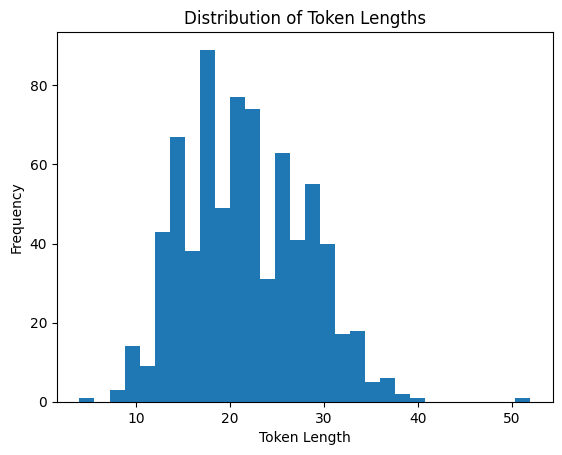

In [5]:
import matplotlib.pyplot as plt

# Visualize the distribution of token lengths in your dataset
token_lengths = [len(tokenizer.encode(text)) for text in df['tweet']]
plt.hist(token_lengths, bins=30)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Choose MAX_LENGTH based on the visualization and your computational resources
MAX_LENGTH = 128  # Adjust this value based on your analysis


In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('l3cube-pune/hing-mbert')
PAD_TOKEN_ID = tokenizer.pad_token_id


def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        max_length=25,  # Define your maximum sequence length
        truncation=True,
        padding='max_length',
        return_tensors='pt',
    )

train_tokens = [tokenize_text(text) for text in train_df['tweet']]
validation_tokens = [tokenize_text(text) for text in validation_df['tweet']]
test_tokens = [tokenize_text(text) for text in test_df['tweet']]




In [6]:
import torch
import torch.nn.utils.rnn as rnn_utils
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

class SRLDataset(Dataset):
    def __init__(self, tokens, semantic_roles):
        self.tokens = tokens
        self.semantic_roles = semantic_roles
        self.label_encoder = LabelEncoder()
        print("Length of self.semantic_roles:", len(self.semantic_roles))
        print("Range of indices:", range(len(self.semantic_roles)))

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        input_ids = self.tokens[idx]['input_ids']
        attention_mask = self.tokens[idx]['attention_mask']

        # Check if idx is within the valid range of indices
        if 0 <= idx < len(self.semantic_roles):
            semantic_roles = self.semantic_roles[idx]
            # Tokenize input features
            # Convert labels to numerical format using label encoding
            encoded_roles = self.label_encoder.fit_transform(semantic_roles)

            # Determine the maximum sequence length in the batch
            max_len = max(len(ids) for ids in input_ids)

            # Pad 'input_ids' and 'attention_mask' for the entire batch
            input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
            attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

            # Pad or truncate 'input_ids' and 'attention_mask' to have the same length
            input_ids = input_ids[:, :max_len]
            attention_mask = attention_mask[:, :max_len]

            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'semantic_roles': torch.tensor(encoded_roles, dtype=torch.long)
            }
        else:
            # Handle the case where idx is out of range
            raise IndexError(f"Index {idx} is out of range for semantic_roles list.")

            
import torch.nn.functional as F


import torch.nn.functional as F

def collate_fn(batch):
    sequences = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['semantic_roles'] for item in batch]

    # Find the maximum length in the batch
    max_len = max(len(seq[0]) for seq in sequences)

    # Ensure the batch size remains consistent
    batch_size = len(batch)

    # Pad sequences and labels to the maximum length
    padded_sequences = rnn_utils.pad_sequence([seq[0] for seq in sequences], batch_first=True, padding_value=PAD_TOKEN_ID)
    padded_attention_masks = rnn_utils.pad_sequence(attention_masks, batch_first=True, padding_value=0)

    # Truncate or pad labels to the maximum length
    padded_labels = [F.pad(label, (0, max_len - len(label)), value=-100) for label in labels]

    # Stack labels
    stacked_labels = torch.stack(padded_labels, dim=0)

    return {
        'input_ids': padded_sequences,
        'attention_mask': padded_attention_masks,
        'semantic_roles': stacked_labels
    }







BATCH_SIZE = 16

# Create datasets and data loaders with collate_fn
train_dataset = SRLDataset(train_tokens, train_df['semantic_roles'])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

validation_dataset = SRLDataset(validation_tokens, validation_df['semantic_roles'])
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_dataset = SRLDataset(test_tokens, test_df['semantic_roles'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)




Length of self.semantic_roles: 595
Range of indices: range(0, 595)
Length of self.semantic_roles: 74
Range of indices: range(0, 74)
Length of self.semantic_roles: 75
Range of indices: range(0, 75)


In [7]:
# Assuming your 'Semantic_Role' column is already converted to lists
unique_labels = set(label for labels in df['semantic_roles'] for label in labels)
num_labels = len(unique_labels)


In [8]:
print(num_labels)

25


In [9]:
# Assuming 'Semantic_Role' column is already converted to lists
unique_labels = set(label for labels in df['semantic_roles'] for label in labels)
print(unique_labels)


{'ARGM_MNR', 'ARGM_DIS', 'ARG1', 'ARG0', 'ARGM_NEG', 'ARG2_ATTr', 'ARG2_ATTRas', 'ARG2_SO', 'ARG2_SOU', 'ARGM_CAU', '_', 'ARGM_DIR', 'ARG3', 'ARG2_GOL', 'ARG2_LOC', 'ARG2', 'ARGM_EXT', 'ARGM_ADV', 'ARG2_ATTR', 'ARG2_CAU', 'ARG2_MNR', 'ARGM_PRP', 'ARGM_TMP', 'ARGM_PRX', 'ARGM_LOC'}


In [10]:
labels = list(unique_labels)
label_to_index = {label: i for i, label in enumerate(labels)}
index_to_label = {i: label for i, label in enumerate(labels)}

num_labels = len(labels)
from sklearn.preprocessing import LabelEncoder

# Example labels
semantic_roles = ['ARGM_DIR', 'ARGM_ADV', 'ARG2_ATTR', 'ARG3', 'ARGM_CAU', 'ARG1', 'ARG2_SOU', 'ARGM_TMP', 'ARG2_LOC', 'ARG0', 'ARGM_MNR', 'ARGM_NEG', 'ARG2_CAU', 'ARG2', 'ARG2_MNR', 'ARGM_PRP', 'ARGM_LOC', 'ARG2_GOL', 'ARG2_ATTr', 'ARGM_DIS', 'ARGM_EXT', '_', 'ARGM_PRX', 'ARG2_ATTRas']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_roles = label_encoder.fit_transform(semantic_roles)

print("Original Labels:", semantic_roles)
print("Encoded Labels:", encoded_roles)

# To inverse transform back to original labels
decoded_roles = label_encoder.inverse_transform(encoded_roles)
print("Decoded Labels:", decoded_roles)

Original Labels: ['ARGM_DIR', 'ARGM_ADV', 'ARG2_ATTR', 'ARG3', 'ARGM_CAU', 'ARG1', 'ARG2_SOU', 'ARGM_TMP', 'ARG2_LOC', 'ARG0', 'ARGM_MNR', 'ARGM_NEG', 'ARG2_CAU', 'ARG2', 'ARG2_MNR', 'ARGM_PRP', 'ARGM_LOC', 'ARG2_GOL', 'ARG2_ATTr', 'ARGM_DIS', 'ARGM_EXT', '_', 'ARGM_PRX', 'ARG2_ATTRas']
Encoded Labels: [14 12  3 11 13  1 10 22  8  0 18 19  6  2  9 20 17  7  5 15 16 23 21  4]
Decoded Labels: ['ARGM_DIR' 'ARGM_ADV' 'ARG2_ATTR' 'ARG3' 'ARGM_CAU' 'ARG1' 'ARG2_SOU'
 'ARGM_TMP' 'ARG2_LOC' 'ARG0' 'ARGM_MNR' 'ARGM_NEG' 'ARG2_CAU' 'ARG2'
 'ARG2_MNR' 'ARGM_PRP' 'ARGM_LOC' 'ARG2_GOL' 'ARG2_ATTr' 'ARGM_DIS'
 'ARGM_EXT' '_' 'ARGM_PRX' 'ARG2_ATTRas']


In [11]:
from transformers import BertForTokenClassification, AdamW
from torch.nn.utils import clip_grad_norm_
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from transformers import BertForTokenClassification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convert 'semantic_roles' to a binary array
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(train_df['semantic_roles'])


model = BertForTokenClassification.from_pretrained('l3cube-pune/hing-mbert', num_labels=num_labels)
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

for fold, (train_index, val_index) in enumerate(kf.split(train_tokens, binary_labels)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split the data into train and validation sets for this fold
    train_fold_tokens = [train_tokens[i] for i in train_index]
    train_fold_labels = [binary_labels[i] for i in train_index]

    val_fold_tokens = [train_tokens[i] for i in val_index]
    val_fold_labels = [binary_labels[i] for i in train_index]

    # Create datasets and data loaders for this fold
    train_fold_dataset = SRLDataset(train_fold_tokens, train_fold_labels)
    val_fold_dataset = SRLDataset(val_fold_tokens, val_fold_labels)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Train the model for NUM_EPOCHS
    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, batch in enumerate(train_fold_loader):
            inputs = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['semantic_roles']

            optimizer.zero_grad()

            outputs = model(input_ids=inputs.squeeze(1), attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()

            # Gradient clipping
            clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

        # Evaluate on the validation set after each epoch
        model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for val_batch in val_fold_loader:
                val_inputs = val_batch['input_ids']
                val_attention_mask = val_batch['attention_mask']
                val_labels = val_batch['semantic_roles']

                val_outputs = model(input_ids=val_inputs.squeeze(1), attention_mask=val_attention_mask)
                logits = val_outputs.logits

                # Convert logits to predictions
                predictions = torch.argmax(F.log_softmax(logits, dim=2), dim=2)

                val_predictions.extend(predictions.tolist())
                val_true_labels.extend(val_labels.tolist())

        # Flatten the predictions and true labels for evaluation
        flat_val_predictions = [label for sublist in val_predictions for label in sublist]
        flat_val_true_labels = [label for sublist in val_true_labels for label in sublist]

        val_accuracy = accuracy_score(flat_val_true_labels, flat_val_predictions)
        print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy}")

# Save the trained model
model.save_pretrained(r"C:\Users\bpsad\Desktop\TRAIN_DATA_PULLED")
print("Model trained")




C:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Some weights of BertForTokenClassification were not initialized from the model checkpoint at l3cube-pune/hing-mbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 1/5
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Epoch 1, Validation Accuracy: 0.8171428571428572
Epoch 2, Validation Accuracy: 0.8430252100840336
Epoch 3, Validation Accuracy: 0.8766386554621849
Epoch 4, Validation Accuracy: 0.8847058823529412
Epoch 5, Validation Accuracy: 0.879327731092437
Fold 2/5
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Epoch 1, Validation Accuracy: 0.8715966386554622
Epoch 2, Validation Accuracy: 0.8826890756302521
Epoch 3, Validation Accuracy: 0.8692436974789916
Epoch 4, Validation Accuracy: 0.8709243697478991
Epoch 5, Validation Accuracy: 0.8742857142857143
Fold 3/5
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Epoch 1, Validation Accuracy: 0.853781512605042
Epoch 2, Validation Accuracy: 0.85

# XLM RoBERTa Base

In [13]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

PAD_TOKEN_ID = tokenizer.pad_token_id


def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        max_length=25,  # Define your maximum sequence length
        truncation=True,
        padding='max_length',
        return_tensors='pt',
    )

train_tokens = [tokenize_text(text) for text in train_df['tweet']]
validation_tokens = [tokenize_text(text) for text in validation_df['tweet']]
test_tokens = [tokenize_text(text) for text in test_df['tweet']]

C:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bpsad\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
from transformers import BertForTokenClassification, AdamW
from torch.nn.utils import clip_grad_norm_
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from transformers import BertForTokenClassification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convert 'semantic_roles' to a binary array
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(train_df['semantic_roles'])


model = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-base", num_labels = num_labels)
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

for fold, (train_index, val_index) in enumerate(kf.split(train_tokens, binary_labels)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split the data into train and validation sets for this fold
    train_fold_tokens = [train_tokens[i] for i in train_index]
    train_fold_labels = [binary_labels[i] for i in train_index]

    val_fold_tokens = [train_tokens[i] for i in val_index]
    val_fold_labels = [binary_labels[i] for i in train_index]

    # Create datasets and data loaders for this fold
    train_fold_dataset = SRLDataset(train_fold_tokens, train_fold_labels)
    val_fold_dataset = SRLDataset(val_fold_tokens, val_fold_labels)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Train the model for NUM_EPOCHS
    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, batch in enumerate(train_fold_loader):
            inputs = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['semantic_roles']

            optimizer.zero_grad()

            outputs = model(input_ids=inputs.squeeze(1), attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()

            # Gradient clipping
            clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

        # Evaluate on the validation set after each epoch
        model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for val_batch in val_fold_loader:
                val_inputs = val_batch['input_ids']
                val_attention_mask = val_batch['attention_mask']
                val_labels = val_batch['semantic_roles']

                val_outputs = model(input_ids=val_inputs.squeeze(1), attention_mask=val_attention_mask)
                logits = val_outputs.logits

                # Convert logits to predictions
                predictions = torch.argmax(F.log_softmax(logits, dim=2), dim=2)

                val_predictions.extend(predictions.tolist())
                val_true_labels.extend(val_labels.tolist())

        # Flatten the predictions and true labels for evaluation
        flat_val_predictions = [label for sublist in val_predictions for label in sublist]
        flat_val_true_labels = [label for sublist in val_true_labels for label in sublist]

        val_accuracy = accuracy_score(flat_val_true_labels, flat_val_predictions)
        print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy}")

# Save the trained model
model.save_pretrained(r"C:\Users\bpsad\Desktop\TRAIN_DATA_PULLED")
print("Model trained")

Some weights of the model checkpoint at FacebookAI/xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 1/5
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Epoch 1, Validation Accuracy: 0.8033613445378152
Epoch 2, Validation Accuracy: 0.8346218487394959
Epoch 3, Validation Accuracy: 0.852436974789916
Epoch 4, Validation Accuracy: 0.8436974789915966
Epoch 5, Validation Accuracy: 0.8342857142857143
Fold 2/5
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Epoch 1, Validation Accuracy: 0.8544537815126051
Epoch 2, Validation Accuracy: 0.8594957983193278
Epoch 3, Validation Accuracy: 0.8484033613445379
Epoch 4, Validation Accuracy: 0.8534453781512605
Epoch 5, Validation Accuracy: 0.8490756302521009
Fold 3/5
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Length of self.semantic_roles: 476
Range of indices: range(0, 476)
Epoch 1, Validation Accuracy: 0.8389915966386554
Epoch 2, Validation Accuracy: 0.8